In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dataset-timeseries/oil.csv
/kaggle/input/dataset-timeseries/sample_submission.csv
/kaggle/input/dataset-timeseries/holidays_events.csv
/kaggle/input/dataset-timeseries/stores.csv
/kaggle/input/dataset-timeseries/train.csv
/kaggle/input/dataset-timeseries/test.csv
/kaggle/input/dataset-timeseries/transactions.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Load datasets
train = pd.read_csv("/kaggle/input/dataset-timeseries/train.csv", parse_dates=["date"])
test = pd.read_csv("/kaggle/input/dataset-timeseries/test.csv", parse_dates=["date"])
stores = pd.read_csv("/kaggle/input/dataset-timeseries/stores.csv")
oil = pd.read_csv("/kaggle/input/dataset-timeseries/oil.csv", parse_dates=["date"])
holidays = pd.read_csv("/kaggle/input/dataset-timeseries/holidays_events.csv", parse_dates=["date"])

# Merge store information
train = train.merge(stores, on="store_nbr", how="left")
test = test.merge(stores, on="store_nbr", how="left")

# Merge oil prices
train = train.merge(oil, on="date", how="left")
test = test.merge(oil, on="date", how="left")

# Merge holiday data
train = train.merge(holidays, on="date", how="left")
test = test.merge(holidays, on="date", how="left")

# Fill missing oil prices with forward fill
train["dcoilwtico"].fillna(method="ffill", inplace=True)
test["dcoilwtico"].fillna(method="ffill", inplace=True)

# Display basic info
print(train.head())
print(train.info())
print(test.info())


   id       date  store_nbr      family  sales  onpromotion   city      state  \
0   0 2013-01-01          1  AUTOMOTIVE    0.0            0  Quito  Pichincha   
1   1 2013-01-01          1   BABY CARE    0.0            0  Quito  Pichincha   
2   2 2013-01-01          1      BEAUTY    0.0            0  Quito  Pichincha   
3   3 2013-01-01          1   BEVERAGES    0.0            0  Quito  Pichincha   
4   4 2013-01-01          1       BOOKS    0.0            0  Quito  Pichincha   

  type_x  cluster  dcoilwtico   type_y    locale locale_name  \
0      D       13         NaN  Holiday  National     Ecuador   
1      D       13         NaN  Holiday  National     Ecuador   
2      D       13         NaN  Holiday  National     Ecuador   
3      D       13         NaN  Holiday  National     Ecuador   
4      D       13         NaN  Holiday  National     Ecuador   

          description transferred  
0  Primer dia del ano       False  
1  Primer dia del ano       False  
2  Primer dia del an

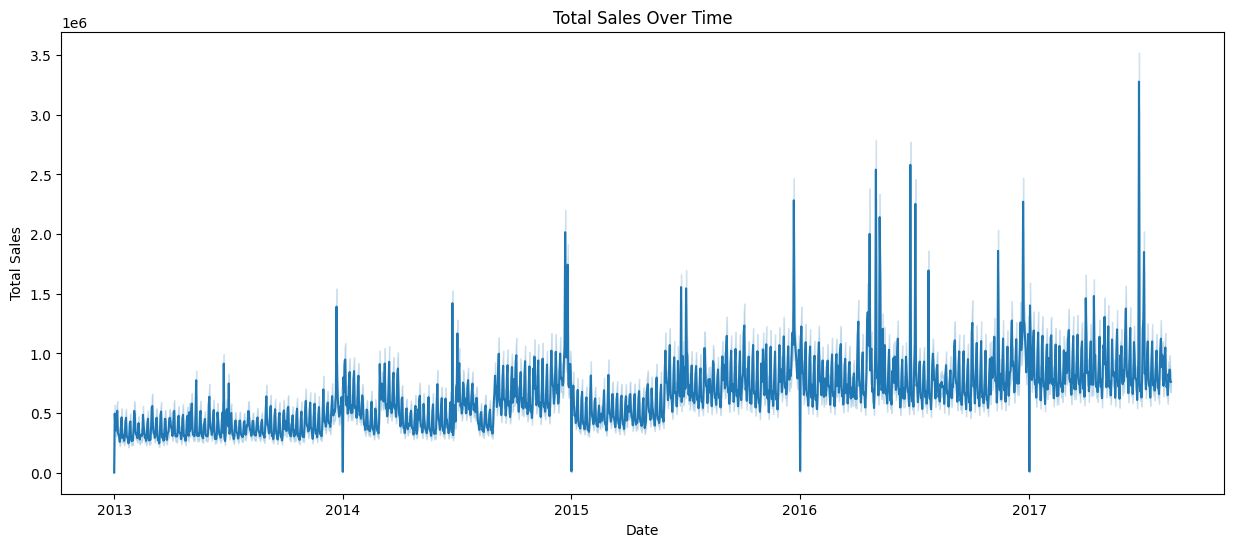

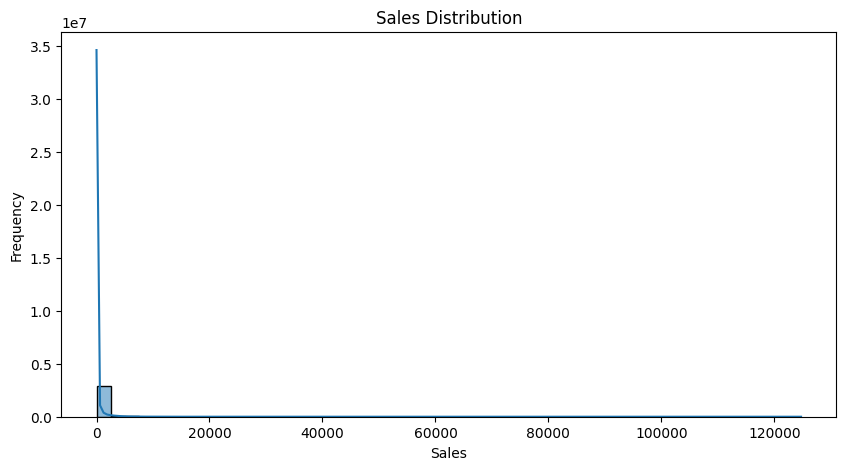

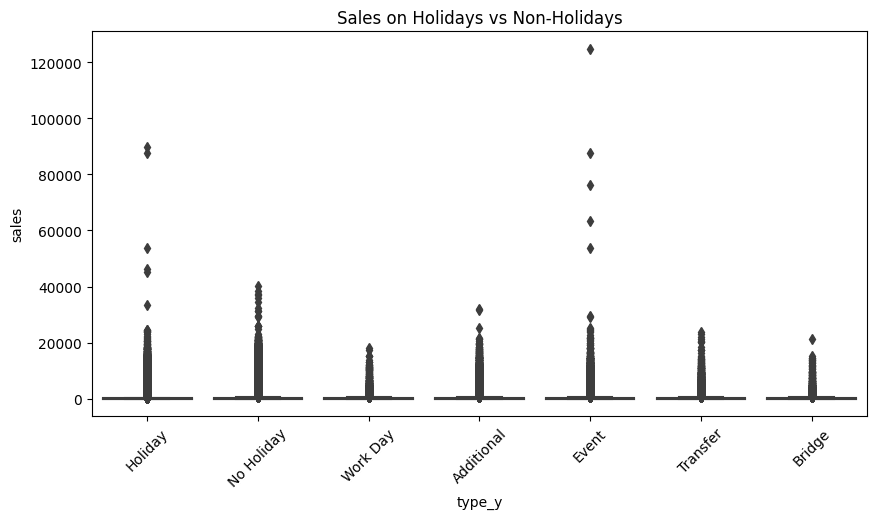

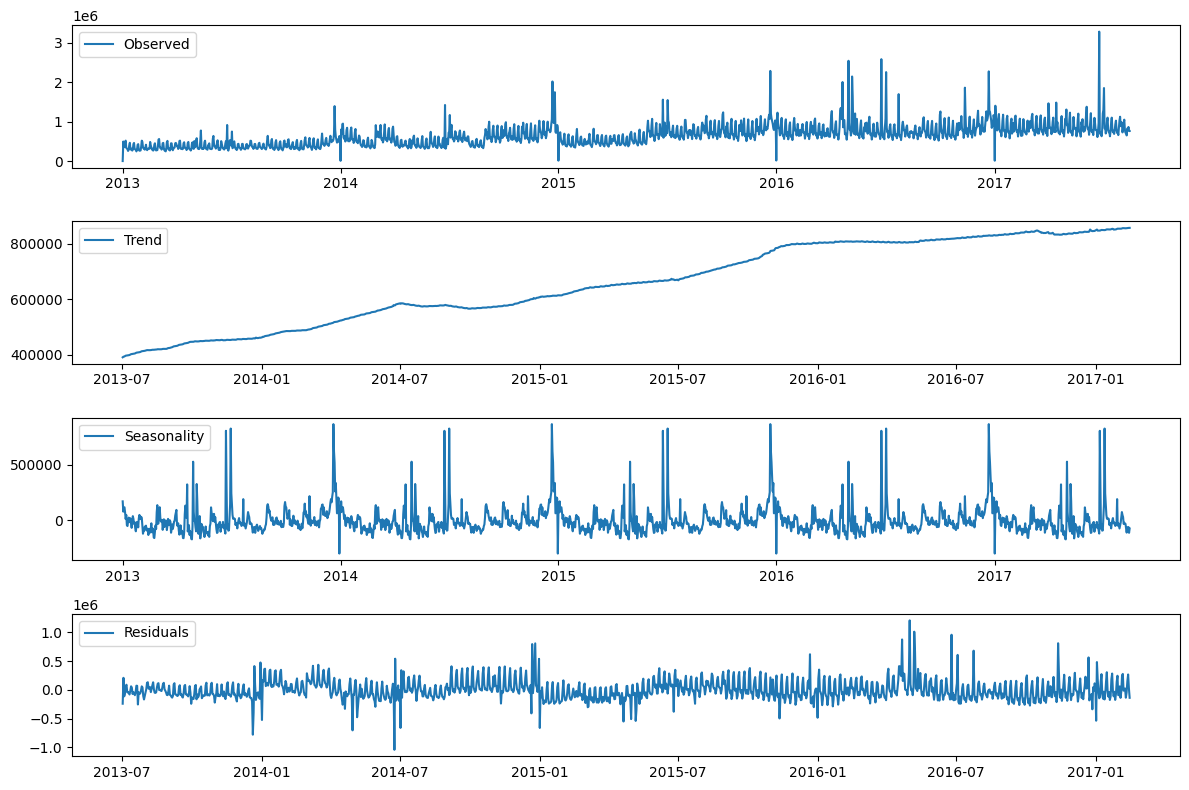

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

# EDA: Sales Trend Over Time
plt.figure(figsize=(15,6))
sns.lineplot(data=train, x="date", y="sales", estimator="sum")
plt.title("Total Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Total Sales")
plt.show()

# EDA: Sales Distribution
plt.figure(figsize=(10,5))
sns.histplot(train["sales"], bins=50, kde=True)
plt.title("Sales Distribution")
plt.xlabel("Sales")
plt.ylabel("Frequency")
plt.show()


plt.figure(figsize=(10,5))
sns.boxplot(x=train["type_y"].fillna("No Holiday"), y=train["sales"])
plt.xticks(rotation=45)
plt.title("Sales on Holidays vs Non-Holidays")
plt.show()

# Time Series Decomposition (Trend, Seasonality, Residuals)
train_store_family = train.groupby("date")["sales"].sum().reset_index()
decomposition = seasonal_decompose(train_store_family.set_index("date")["sales"], model="additive", period=365)

plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(decomposition.observed, label="Observed")
plt.legend()

plt.subplot(412)
plt.plot(decomposition.trend, label="Trend")
plt.legend()

plt.subplot(413)
plt.plot(decomposition.seasonal, label="Seasonality")
plt.legend()

plt.subplot(414)
plt.plot(decomposition.resid, label="Residuals")
plt.legend()

plt.tight_layout()
plt.show()



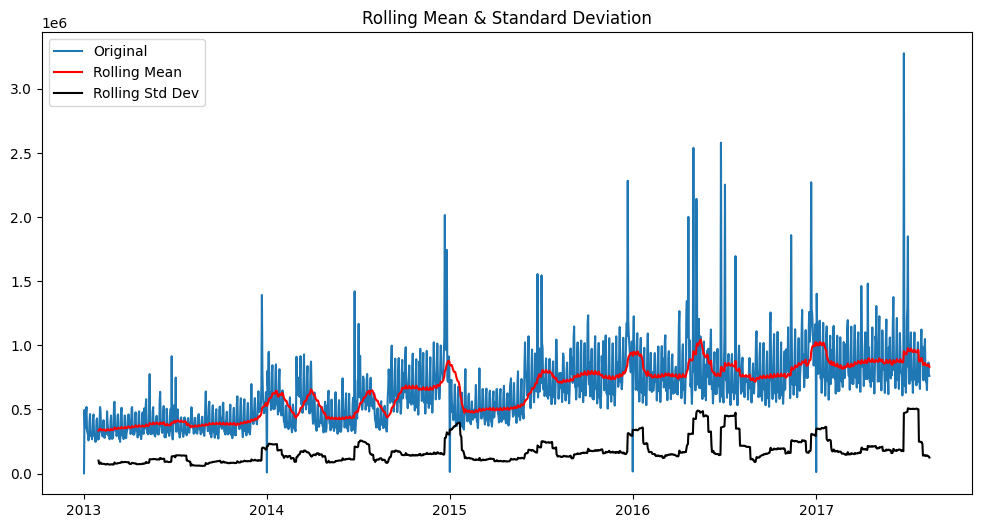

ADF Test:
ADF Statistic: -2.9316458403999253
p-value: 0.041789840054320446
Critical Values:
   1%: -3.4342954463097706
   5%: -2.8632826898390484
   10%: -2.5676977663666714
Data is stationary (Reject H0)


In [5]:
# Stationarity Check - ADF Test
def adf_test(timeseries):
    result = adfuller(timeseries)
    print("ADF Test:")
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    print("Critical Values:")
    for key, value in result[4].items():
        print(f"   {key}: {value}")
    if result[1] <= 0.05:
        print("Data is stationary (Reject H0)")
    else:
        print("Data is not stationary (Fail to reject H0)")

# Plot rolling mean and standard deviation
rolling_mean = train_store_family["sales"].rolling(window=30).mean()
rolling_std = train_store_family["sales"].rolling(window=30).std()

plt.figure(figsize=(12,6))
plt.plot(train_store_family["date"], train_store_family["sales"], label="Original")
plt.plot(train_store_family["date"], rolling_mean, label="Rolling Mean", color='red')
plt.plot(train_store_family["date"], rolling_std, label="Rolling Std Dev", color='black')
plt.title("Rolling Mean & Standard Deviation")
plt.legend()
plt.show()

# Run ADF Test
adf_test(train_store_family["sales"])

In [6]:
train

,id,date,store_nbr,family,sales,onpromotion,city,state,type_x,cluster,dcoilwtico,type_y,locale,locale_name,description,transferred
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False
1,1,2013-01-01,1,BABY CARE,0.000,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False
2,2,2013-01-01,1,BEAUTY,0.000,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False
3,3,2013-01-01,1,BEVERAGES,0.000,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False
4,4,2013-01-01,1,BOOKS,0.000,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3054343,3000883,2017-08-15,9,POULTRY,438.133,0,Quito,Pichincha,B,6,47.57,Holiday,Local,Riobamba,Fundacion de Riobamba,False
3054344,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,Quito,Pichincha,B,6,47.57,Holiday,Local,Riobamba,Fundacion de Riobamba,False
3054345,3000885,2017-08-15,9,PRODUCE,2419.729,148,Quito,Pichincha,B,6,47.57,Holiday,Local,Riobamba,Fundacion de Riobamba,False
3054346,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,Quito,Pichincha,B,6,47.57,Holiday,Local,Riobamba,Fundacion de Riobamba,False


In [7]:
from sklearn.metrics import mean_squared_log_error

# Baseline Model: Naïve Forecast (Last Observed Value)
naive_forecast = train_store_family["sales"].iloc[-15:].values  # Last 15 days as prediction
actual_sales = test["sales"].values if "sales" in test.columns else np.zeros(15)  # Placeholder for actual test sales

# Compute RMSLE
rmsle_naive = np.sqrt(mean_squared_log_error(actual_sales, naive_forecast))
print(f"Baseline Naïve Model RMSLE: {rmsle_naive}")

Baseline Naïve Model RMSLE: 13.619648226793846


In [9]:
from statsmodels.tsa.arima.model import ARIMA
# ARIMA Model
p, d, q = 5, 1, 0  # Initial values (can be tuned)
train_series = train_store_family.set_index("date")["sales"]

model_arima = ARIMA(train_series, order=(p, d, q))
model_arima_fit = model_arima.fit()

# Forecast for next 15 days
arima_forecast = model_arima_fit.forecast(steps=15)

# Compute RMSLE
rmsle_arima = np.sqrt(mean_squared_log_error(actual_sales, arima_forecast))
print(f"ARIMA Model RMSLE: {rmsle_arima}")

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA Model RMSLE: 13.561502664554807


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [10]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
# SARIMA Model
P, D, Q, s = 1, 1, 1, 7  # Seasonal parameters (can be tuned)
model_sarima = SARIMAX(train_series, order=(p, d, q), seasonal_order=(P, D, Q, s), enforce_stationarity=False, enforce_invertibility=False)
model_sarima_fit = model_sarima.fit()

# Forecast for next 15 days
sarima_forecast = model_sarima_fit.forecast(steps=15)

# Compute RMSLE
rmsle_sarima = np.sqrt(mean_squared_log_error(actual_sales, sarima_forecast))
print(f"SARIMA Model RMSLE: {rmsle_sarima}")

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA Model RMSLE: 13.493863270450552


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [12]:
train

,id,date,store_nbr,family,sales,onpromotion,city,state,type_x,cluster,dcoilwtico,type_y,locale,locale_name,description,transferred
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False
1,1,2013-01-01,1,BABY CARE,0.000,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False
2,2,2013-01-01,1,BEAUTY,0.000,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False
3,3,2013-01-01,1,BEVERAGES,0.000,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False
4,4,2013-01-01,1,BOOKS,0.000,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3054343,3000883,2017-08-15,9,POULTRY,438.133,0,Quito,Pichincha,B,6,47.57,Holiday,Local,Riobamba,Fundacion de Riobamba,False
3054344,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,Quito,Pichincha,B,6,47.57,Holiday,Local,Riobamba,Fundacion de Riobamba,False
3054345,3000885,2017-08-15,9,PRODUCE,2419.729,148,Quito,Pichincha,B,6,47.57,Holiday,Local,Riobamba,Fundacion de Riobamba,False
3054346,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,Quito,Pichincha,B,6,47.57,Holiday,Local,Riobamba,Fundacion de Riobamba,False


In [13]:
##XGBOOST
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Feature Engineering
train["day_of_week"] = train["date"].dt.dayofweek
test["day_of_week"] = test["date"].dt.dayofweek
train["month"] = train["date"].dt.month
test["month"] = test["date"].dt.month
train["year"] = train["date"].dt.year
test["year"] = test["date"].dt.year
train["is_weekend"] = (train["day_of_week"] >= 5).astype(int)
test["is_weekend"] = (test["day_of_week"] >= 5).astype(int)
train["is_holiday"] = train["type_y"].notna().astype(int)
test["is_holiday"] = test["type_y"].notna().astype(int)

In [14]:
train

,id,date,store_nbr,family,sales,onpromotion,city,state,type_x,cluster,...,type_y,locale,locale_name,description,transferred,day_of_week,month,year,is_weekend,is_holiday
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0,Quito,Pichincha,D,13,...,Holiday,National,Ecuador,Primer dia del ano,False,1,1,2013,0,1
1,1,2013-01-01,1,BABY CARE,0.000,0,Quito,Pichincha,D,13,...,Holiday,National,Ecuador,Primer dia del ano,False,1,1,2013,0,1
2,2,2013-01-01,1,BEAUTY,0.000,0,Quito,Pichincha,D,13,...,Holiday,National,Ecuador,Primer dia del ano,False,1,1,2013,0,1
3,3,2013-01-01,1,BEVERAGES,0.000,0,Quito,Pichincha,D,13,...,Holiday,National,Ecuador,Primer dia del ano,False,1,1,2013,0,1
4,4,2013-01-01,1,BOOKS,0.000,0,Quito,Pichincha,D,13,...,Holiday,National,Ecuador,Primer dia del ano,False,1,1,2013,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3054343,3000883,2017-08-15,9,POULTRY,438.133,0,Quito,Pichincha,B,6,...,Holiday,Local,Riobamba,Fundacion de Riobamba,False,1,8,2017,0,1
3054344,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,Quito,Pichincha,B,6,...,Holiday,Local,Riobamba,Fundacion de Riobamba,False,1,8,2017,0,1
3054345,3000885,2017-08-15,9,PRODUCE,2419.729,148,Quito,Pichincha,B,6,...,Holiday,Local,Riobamba,Fundacion de Riobamba,False,1,8,2017,0,1
3054346,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,Quito,Pichincha,B,6,...,Holiday,Local,Riobamba,Fundacion de Riobamba,False,1,8,2017,0,1


In [16]:
# Feature engineering
def create_features(df, is_train=True):
    df['date'] = pd.to_datetime(df['date'])
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['day_of_week'] = df['date'].dt.dayofweek
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
    
    if is_train:
        # Lag features for training data
        df['sales_lag_7'] = df.groupby(['store_nbr', 'family'])['sales'].shift(7)
        df['sales_lag_14'] = df.groupby(['store_nbr', 'family'])['sales'].shift(14)
        
        # Rolling statistics for training data
        df['sales_rolling_mean_7'] = df.groupby(['store_nbr', 'family'])['sales'].transform(lambda x: x.rolling(window=7).mean())
        df['sales_rolling_std_7'] = df.groupby(['store_nbr', 'family'])['sales'].transform(lambda x: x.rolling(window=7).std())
    else:
        # For test data, create lag features using the last available sales data
        last_sales = train.groupby(['store_nbr', 'family'])['sales'].last().reset_index()
        last_sales = last_sales.rename(columns={'sales': 'sales_lag_7'})
        df = df.merge(last_sales, on=['store_nbr', 'family'], how='left')
        
        last_sales_14 = train.groupby(['store_nbr', 'family'])['sales'].apply(lambda x: x.iloc[-14]).reset_index()
        last_sales_14 = last_sales_14.rename(columns={'sales': 'sales_lag_14'})
        df = df.merge(last_sales_14, on=['store_nbr', 'family'], how='left')
        
        # Rolling statistics for test data (use the last rolling values from training data)
        last_rolling_mean = train.groupby(['store_nbr', 'family'])['sales'].apply(lambda x: x.rolling(window=7).mean().iloc[-1]).reset_index()
        last_rolling_mean = last_rolling_mean.rename(columns={'sales': 'sales_rolling_mean_7'})
        df = df.merge(last_rolling_mean, on=['store_nbr', 'family'], how='left')
        
        last_rolling_std = train.groupby(['store_nbr', 'family'])['sales'].apply(lambda x: x.rolling(window=7).std().iloc[-1]).reset_index()
        last_rolling_std = last_rolling_std.rename(columns={'sales': 'sales_rolling_std_7'})
        df = df.merge(last_rolling_std, on=['store_nbr', 'family'], how='left')
    
    return df

In [17]:
# Apply feature engineering
train = create_features(train, is_train=True)
test = create_features(test, is_train=False)

In [18]:
train

,id,date,store_nbr,family,sales,onpromotion,city,state,type_x,cluster,...,day_of_week,month,year,is_weekend,is_holiday,day,sales_lag_7,sales_lag_14,sales_rolling_mean_7,sales_rolling_std_7
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0,Quito,Pichincha,D,13,...,1,1,2013,0,1,1,NaN,NaN,NaN,NaN
1,1,2013-01-01,1,BABY CARE,0.000,0,Quito,Pichincha,D,13,...,1,1,2013,0,1,1,NaN,NaN,NaN,NaN
2,2,2013-01-01,1,BEAUTY,0.000,0,Quito,Pichincha,D,13,...,1,1,2013,0,1,1,NaN,NaN,NaN,NaN
3,3,2013-01-01,1,BEVERAGES,0.000,0,Quito,Pichincha,D,13,...,1,1,2013,0,1,1,NaN,NaN,NaN,NaN
4,4,2013-01-01,1,BOOKS,0.000,0,Quito,Pichincha,D,13,...,1,1,2013,0,1,1,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3054343,3000883,2017-08-15,9,POULTRY,438.133,0,Quito,Pichincha,B,6,...,1,8,2017,0,1,15,358.132,570.196000,381.083426,86.433346
3054344,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,Quito,Pichincha,B,6,...,1,8,2017,0,1,15,112.954,50.462997,121.605856,16.673439
3054345,3000885,2017-08-15,9,PRODUCE,2419.729,148,Quito,Pichincha,B,6,...,1,8,2017,0,1,15,2299.715,2470.461000,1525.855714,439.927872
3054346,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,Quito,Pichincha,B,6,...,1,8,2017,0,1,15,170.000,203.000000,144.571429,38.504793


,id,date,store_nbr,family,sales,onpromotion,city,state,type_x,cluster,...,quarter,day_of_year,promo_flag,sales_lag_1,sales_lag_3,sales_lag_28,sales_rolling_mean_14,sales_rolling_std_14,sales_rolling_mean_28,sales_rolling_std_28
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0,Quito,Pichincha,D,13,...,1,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2013-01-01,1,BABY CARE,0.000,0,Quito,Pichincha,D,13,...,1,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2013-01-01,1,BEAUTY,0.000,0,Quito,Pichincha,D,13,...,1,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,2013-01-01,1,BEVERAGES,0.000,0,Quito,Pichincha,D,13,...,1,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,2013-01-01,1,BOOKS,0.000,0,Quito,Pichincha,D,13,...,1,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3054343,3000883,2017-08-15,9,POULTRY,438.133,0,Quito,Pichincha,B,6,...,3,227,0,283.429,383.387000,320.401,437.880281,105.582330,427.415748,100.876021
3054344,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,Quito,Pichincha,B,6,...,3,227,1,114.120,129.903990,118.927,120.867428,23.384617,104.266357,33.036637
3054345,3000885,2017-08-15,9,PRODUCE,2419.729,148,Quito,Pichincha,B,6,...,3,227,1,1348.425,1419.264000,2178.149,1606.105500,392.277583,1586.302607,418.375348
3054346,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,Quito,Pichincha,B,6,...,3,227,1,182.000,138.000000,0.000,150.071429,30.225980,87.464286,76.873384


In [19]:
# Drop problematic columns (object types)
drop_columns = ['locale', 'locale_name', 'description', 'transferred']
train = train.drop(columns=drop_columns)
test = test.drop(columns=drop_columns)

In [20]:
# Encode categorical variables
categorical_cols = ['family', 'city', 'state', 'type_x', 'type_y']
train = pd.get_dummies(train, columns=categorical_cols)
test = pd.get_dummies(test, columns=categorical_cols)

# Ensure both train and test have the same columns after encoding
# Add missing columns to test and fill with 0
for col in train.columns:
    if col not in test.columns and col != 'sales':
        test[col] = 0

# Reorder test columns to match train
test = test[train.columns.drop('sales')]

In [26]:
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Prepare data for modeling
X_train = train.drop(['id', 'date', 'sales'], axis=1)
y_train = train['sales']
X_test = test.drop(['id', 'date'], axis=1)

# Time-series cross-validation
tscv = TimeSeriesSplit(n_splits=5)
rmsle_scores = []
mse_scores = []
rmse_scores = []
r2scores = []

for train_index, val_index in tscv.split(X_train):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
    
    # Train XGBoost model
    model = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=1000,
        learning_rate=0.05,
        max_depth=8,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )
    model.fit(X_train_fold, y_train_fold, eval_set=[(X_val_fold, y_val_fold)], early_stopping_rounds=50, verbose=False)
    
    # Predict on validation set
    y_pred_fold = model.predict(X_val_fold)
    
    # Clip predictions to ensure non-negative values
    y_pred_fold = np.clip(y_pred_fold, 0, None)
    
    # Calculate RMSLE
    rmsle = np.sqrt(mean_squared_log_error(y_val_fold, y_pred_fold))
    rmsle_scores.append(rmsle)
    print(f"Fold RMSLE: {rmsle}")
    
    # Calculate MLE
    mse = mean_squared_error(y_val_fold, y_pred_fold)
    mse_scores.append(mse)   

    # Calculate RMSE
    rmse = np.sqrt(mse)
    rmse_scores.append(rmse)

    # Calculate R2
    r2 = r2_score(y_val_fold, y_pred_fold)
    r2scores.append(r2)

# Store RMSLE values for model comparison

print(f"Average RMSLE: {np.mean(rmsle_scores)}")

# Train final model on full training data
final_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
final_model.fit(X_train, y_train)

# Predict on test set
predictions = final_model.predict(X_test)

# Clip predictions to ensure non-negative values
predictions = np.clip(predictions, 0, None)

#Prepare submission file
submission = pd.DataFrame({'id': test['id'], 'sales': predictions})
submission.to_csv('submission.csv', index=False)

print("Submission file created")

Fold RMSLE: 0.9655234942348064
Fold RMSLE: 0.9612787153644105
Fold RMSLE: 0.5271394680130569
Fold RMSLE: 0.4811449223365515
Fold RMSLE: 0.5169890240425841
Average RMSLE: 0.6904151247982819


In [28]:
import re
import lightgbm as lgb
# Function to clean column names
def clean_column_names(df):
    df.columns = [re.sub(r'[^A-Za-z0-9_]', '', col) for col in df.columns]
    return df

# Apply cleaning to column names
X_train = clean_column_names(X_train)
X_test = clean_column_names(X_test)

# LightGBM Model
rmsle_scores_lgb = []
mse_scores_lgb = []
rmse_scores_lgb = []
r2_scores_lgb = []
metrics_summary = []

for train_index, val_index in tscv.split(X_train):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
    
    model_lgb = lgb.LGBMRegressor(
        n_estimators=1000,
        learning_rate=0.05,
        max_depth=8,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )
    model_lgb.fit(
        X_train_fold, y_train_fold,
        eval_set=[(X_val_fold, y_val_fold)],
        eval_names=['validation'],
        callbacks=[lgb.early_stopping(50), lgb.log_evaluation(50)]
    )
    
    y_pred_fold = np.clip(model_lgb.predict(X_val_fold), 0, None)
    rmsle_scores_lgb.append(np.sqrt(mean_squared_log_error(y_val_fold, y_pred_fold)))
    mse_scores_lgb.append(mean_squared_error(y_val_fold, y_pred_fold))
    rmse_scores_lgb.append(np.sqrt(mse))
    r2_scores_lgb.append(r2_score(y_val_fold, y_pred_fold))   
    print(f"LightGBM Fold RMSLE: {rmsle_scores_lgb[-1]}")

metrics_summary = {
    "Model": ["XGBoost", "LightGBM"],
    "MSE": [np.mean(mse_scores), np.mean(mse_scores_lgb)],
    "RMSE": [np.mean(rmse_scores), np.mean(rmse_scores_lgb)],
    "RMSLE": [np.mean(rmsle_scores), np.mean(rmsle_scores_lgb)],
    "R² Score": [np.mean(r2scores), np.mean(r2_scores_lgb)]
}

print(f"LightGBM Average RMSLE: {np.mean(rmsle_scores_lgb)}")

# Train final LightGBM model
final_model_lgb = lgb.LGBMRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
final_model_lgb.fit(X_train, y_train)

# Predict on test set using LightGBM
predictions_lgb = np.clip(final_model_lgb.predict(X_test), 0, None)

# Compare models and choose best one
if np.mean(rmsle_scores) < np.mean(rmsle_scores_lgb):
    best_model_name = "XGBoost"
    best_predictions = predictions
else:
    best_model_name = "LightGBM"
    best_predictions = predictions_lgb

print(f"Best Model: {best_model_name}")

# Prepare submission file
submission = pd.DataFrame({'id': test['id'], 'sales': best_predictions})
submission.to_csv('submission.csv', index=False)
print("Submission file created")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027374 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1491
[LightGBM] [Info] Number of data points in the train set: 509058, number of used features: 92
[LightGBM] [Info] Start training from score 207.051060
Training until validation scores don't improve for 50 rounds
[50]	validation's l2: 68787.2
[100]	validation's l2: 59542.5
[150]	validation's l2: 57854.4
[200]	validation's l2: 56856.6
[250]	validation's l2: 55973.6
[300]	validation's l2: 55216.2
[350]	validation's l2: 54902.1
[400]	validation's l2: 54448.6
[450]	validation's l2: 54251.1
[500]	validation's l2: 53996.3
[550]	validation's l2: 53832.1
[600]	validation's l2: 53754.5
[650]	validation's l2: 53803.7
Early stopping, best iteration is:
[620]	validation's l2: 53726.7
LightGBM Fold RMSLE: 0.698222383936668
[LightGBM] [Info] Auto-

In [29]:
#Comparison between the Evaluation metrices

import pandas as pd
df_results = pd.DataFrame(metrics_summary)
print("\n📊 Cross-Validation Performance Comparison:")
print(df_results)


📊 Cross-Validation Performance Comparison:
      Model           MSE        RMSE     RMSLE  R² Score
0   XGBoost  76365.454339  270.071159  0.690415  0.942879
1  LightGBM  73882.475953  274.021204  0.654207  0.944819
